In [1]:
from DataLoader import *
from Visualization import *
from EstimateFundamentalMatrix import *
from EssentialMatrixFromFundamentalMatrix import *
from GetInliersRANSAC import *
from ExtractCameraPose import *
from LinearTriangulation import *
from DisambiguateCameraPose import *
from NonlinearTriangulation import *
import os

# Don't generate pyc codes
sys.dont_write_bytecode = True

In [2]:
dataDirPath = os.getcwd() + '/P3Data/'
images = loadImages(dataDirPath)
# displayImages(images, 5)


In [3]:
K = getCameraParams(dataDirPath)
print(K)

[[531.12215532   0.         407.19255084]
 [  0.         531.5417375  313.30871505]
 [  0.           0.           1.        ]]


In [4]:
featureMatchesList = parseMatchFiles(dataDirPath)

In [5]:
matchId = 0
image1Id = 0
image2Id = 1
InlierList, OutlierList = homographyRANSAC(featureMatchesList[matchId].matchPairs, 2000, 50)
matchPairsInliers_homography = [featureMatchesList[matchId].matchPairs[i] for i in InlierList]
matchPairsOutliers_homography = [featureMatchesList[matchId].matchPairs[i] for i in OutlierList]
InlierList, OutlierList = ransac(matchPairsInliers_homography, 10000, 0.01)
matchPairsInliers = [matchPairsInliers_homography[i] for i in InlierList]
matchPairsOutliers = [matchPairsInliers_homography[i] for i in OutlierList]


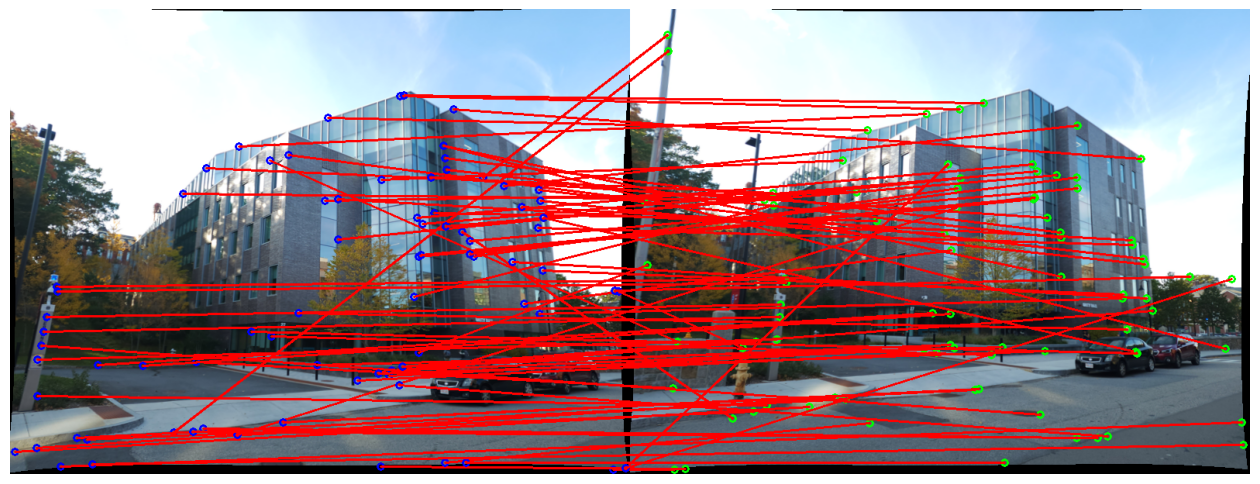

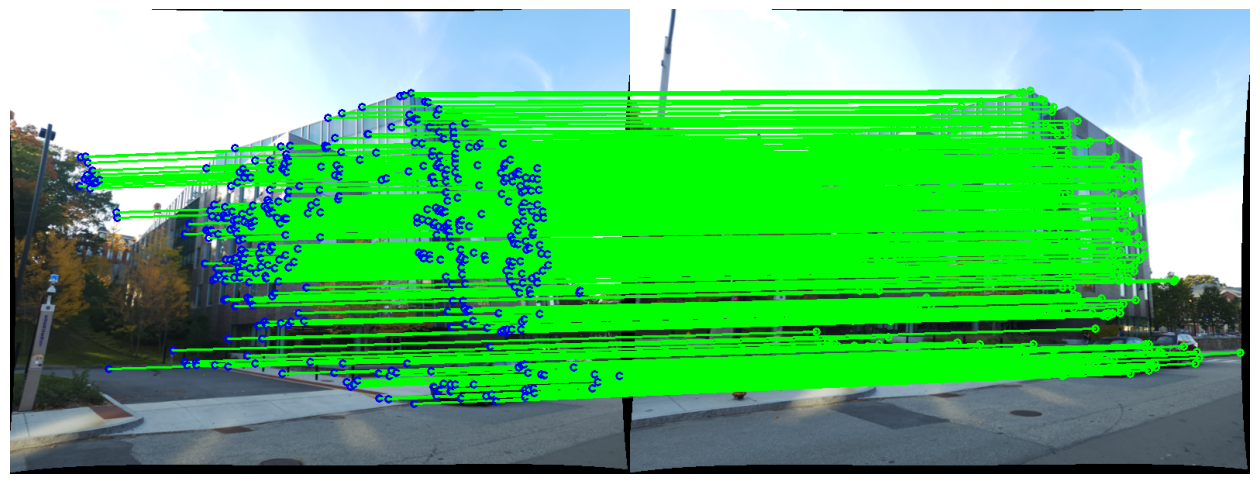

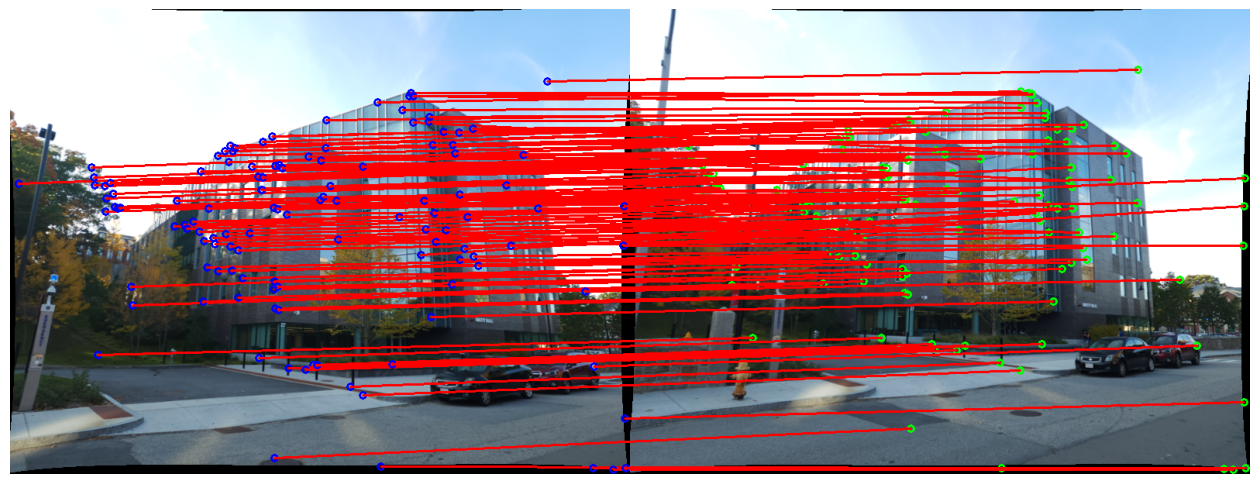

In [6]:
matchImage0 = drawMatchs(images[image1Id], images[image2Id], matchPairsOutliers_homography, (255,0,0))
matchImage1 = drawMatchs(images[image1Id], images[image2Id], matchPairsInliers, (0,255,0))
matchImage2 = drawMatchs(images[image1Id], images[image2Id], matchPairsOutliers, (255,0,0))
plt.figure(figsize=(16, 8))
plt.axis("off")
plt.imshow(matchImage0)
plt.show()
plt.figure(figsize=(16, 8))
plt.axis("off")
plt.imshow(matchImage1)
plt.show()
plt.figure(figsize=(16, 8))
plt.axis("off")
plt.imshow(matchImage2)
plt.show()

## Final Fundimental Matrix Calculated from inliers

In [7]:
x1s = []
x2s = []
for idx in range(len(matchPairsInliers)):
    x1s.append(matchPairsInliers[idx].coords1)
    x2s.append(matchPairsInliers[idx].coords2)
x1s = np.array(x1s)
x2s = np.array(x2s)

Fest = EstimateFundamentalMatrix(x1s, x2s)
print(Fest)


[[-1.62259469e-08 -2.95052214e-05  1.27014664e-02]
 [ 3.19628273e-05  3.07648884e-06 -3.42790037e-02]
 [-1.45300026e-02  3.25249527e-02  9.98696464e-01]]


## Estimate Essential Matrix from Fundimental Matrix

In [8]:
Eest = EssentialFromFundamental(Fest, K)
print(Eest)

[[ 0.00253308 -0.58175938  0.12464714]
 [ 0.63391322  0.05270502 -0.75619935]
 [-0.17272979  0.79934798  0.02754419]]


## Estimate Camera Pose

In [9]:
Rest, Test = extractCameraPose(Eest)
print(Rest)
print(Test)

[array([[ 0.21501451,  0.20549896,  0.95474548],
       [ 0.25594809, -0.95529758,  0.14797672],
       [ 0.94247511,  0.21254814, -0.25799991]]), array([[ 0.21501451,  0.20549896,  0.95474548],
       [ 0.25594809, -0.95529758,  0.14797672],
       [ 0.94247511,  0.21254814, -0.25799991]]), array([[ 0.99682176,  0.02081609,  0.07689648],
       [-0.02462702,  0.99849767,  0.048948  ],
       [-0.07576205, -0.05068617,  0.99583685]]), array([[ 0.99682176,  0.02081609,  0.07689648],
       [-0.02462702,  0.99849767,  0.048948  ],
       [-0.07576205, -0.05068617,  0.99583685]])]
[array([0.80374915, 0.15342346, 0.57484654]), array([-0.80374915, -0.15342346, -0.57484654]), array([0.80374915, 0.15342346, 0.57484654]), array([-0.80374915, -0.15342346, -0.57484654])]


## Triangulation Check for Cheirality Condition

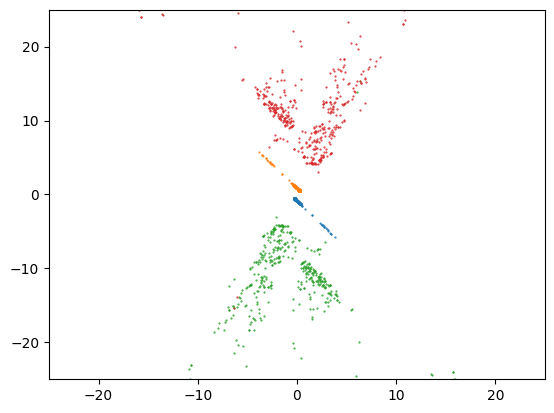

In [10]:
Xest = []
for i in range(len(Rest)):
    X = LinearTriangulation(K, x1s, x2s, np.eye(3), np.zeros((3,1)), Rest[i], Test[i])
    Xest.append(X)

drawWorldPoints(Xest)
Rest, Test, Xest = disambiguateCameraPose(Rest, Test, Xest)


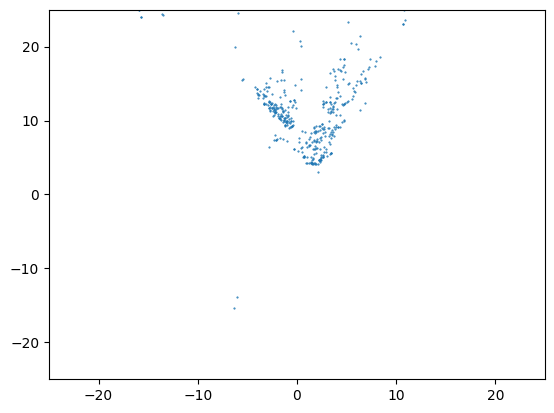

In [11]:
drawWorldPoints([Xest])
# drawWorldPoints(Xest)
# drawWorldPoints([Xest[0]])
# drawWorldPoints([Xest[1]])
# drawWorldPoints([Xest[2]])
# drawWorldPoints([Xest[3]])

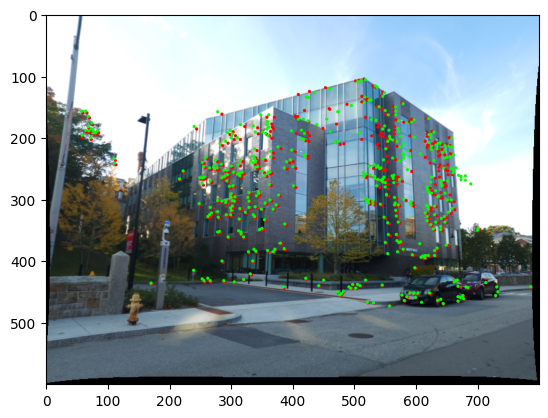

In [12]:
newImage = drawPoints(images[image1Id], x1s, [255, 0, 0])

reprojPoints = reprojection(K, np.eye(3), np.zeros((3,1)), Xest)
newImage = drawPoints(newImage, reprojPoints, [0, 255, 0])

plt.imshow(newImage)
plt.show()

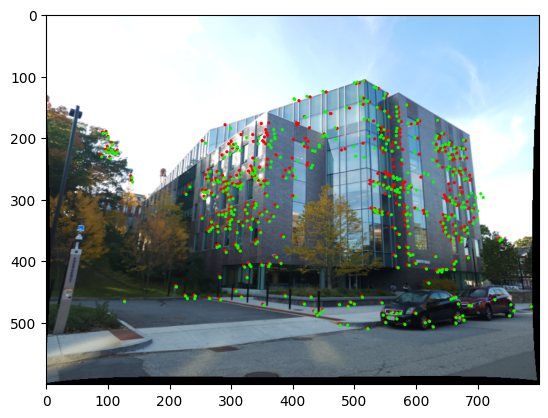

In [13]:
newImage2 = drawPoints(images[image2Id], x2s, [255, 0, 0])

reprojPoints2 = reprojection(K, Rest, Test, Xest)
newImage2 = drawPoints(newImage2, reprojPoints2, [0, 255, 0])

plt.imshow(newImage2)
plt.show()

In [14]:
XestNonlinear = nonlinearTriangulation(K, np.eye(3), np.zeros((3,1)), Rest, Test, x1s, x2s, Xest)

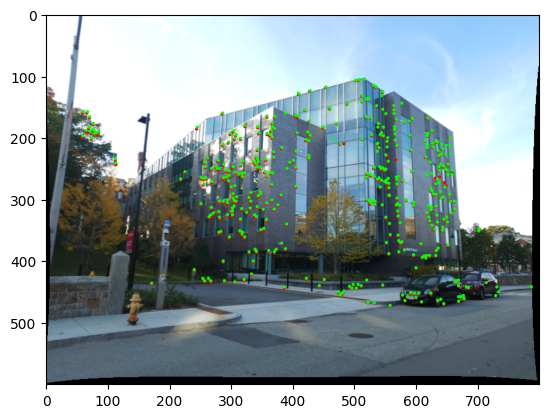

In [15]:
newImage = drawPoints(images[image1Id], x1s, [255, 0, 0])

reprojPoints = reprojection(K, np.eye(3), np.zeros((3,1)), XestNonlinear)
newImage = drawPoints(newImage, reprojPoints, [0, 255, 0])

plt.imshow(newImage)
plt.show()

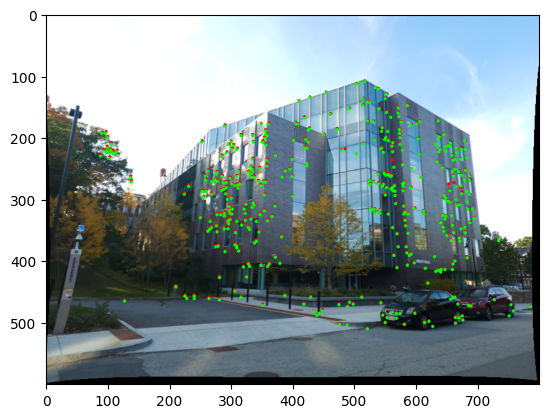

In [16]:
newImage2 = drawPoints(images[image2Id], x2s, [255, 0, 0])

reprojPoints2 = reprojection(K, Rest, Test, XestNonlinear)
newImage2 = drawPoints(newImage2, reprojPoints2, [0, 255, 0])

plt.imshow(newImage2)
plt.show()

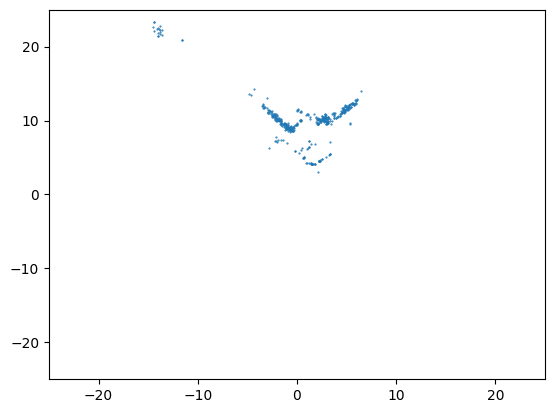

In [17]:
drawWorldPoints([XestNonlinear])